## Task: Predict Customers who will default on a loan.

### IMPORT NECESSARY LIBRARIES

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import  GradientBoostingClassifier,RandomForestClassifier
import lightgbm as lgbm
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.linear_model import  LinearRegression, Ridge
import os, gc, warnings
warnings.filterwarnings('ignore')





### READING DATASETS INTO PANDA'S DATAFRAME....

In [2]:
Train = pd.read_csv('Train (3).csv')
Test = pd.read_csv('Test (3).csv')
submission = pd.read_csv('SampleSubmission (1).csv')

### DEFINING FUNCTIONS AND CLASSES TO BE USED...

In [3]:

def fill_arbitary(col):
    for i in col:
        b = -999999
        Train[i].fillna(b,inplace=True)
        Test[i].fillna(b,inplace= True)  



In [29]:
def lgb_predict(estimator,train,label,test,estimator_name):
    mean_train = []
    mean_test_val = []
    test_pred = np.zeros(test.shape[0])
    val_pred = np.zeros(train.shape[0])
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = label.iloc[train_index],label.iloc[test_index]
        print(f'========================Fold{count +1}==========================')
        estimator.fit(x_train,y_train,eval_set=[(x_test,y_test)],early_stopping_rounds=200,
                               verbose=250)
        train_predict = estimator.predict_proba(x_train, num_iteration = estimator.best_iteration_)[:,1]
        test_predict = estimator.predict_proba(x_test, num_iteration = estimator.best_iteration_)[:,1]
        val_pred[test_index] = test_predict
        test_pred+= estimator.predict_proba(test, num_iteration = estimator.best_iteration_)[:,1]
        
        print('\nValidation scores', roc_auc_score(y_test,test_predict))
        print('\nTraining scores', roc_auc_score(y_train,train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test_val.append(roc_auc_score(y_test,test_predict))
    print('Average Testing ROC score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training ROC score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name


def xgb_predict(estimator,train,label,test,estimator_name):
    mean_train = []
    mean_test_val = []
    test_pred = np.zeros(test.shape[0])
    val_pred = np.zeros(train.shape[0])
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = label.iloc[train_index],label.iloc[test_index]
        print(f'========================Fold{count +1}==========================')
        estimator.fit(x_train, y_train, early_stopping_rounds = 200, eval_metric="auc",
                           eval_set=[(x_test, y_test)],verbose=250)
        train_predict = estimator.predict_proba(x_train, ntree_limit = estimator.get_booster().best_ntree_limit)[:,1]
        test_predict = estimator.predict_proba(x_test, ntree_limit = estimator.get_booster().best_ntree_limit)[:,1]
        val_pred[test_index] = test_predict
        test_pred+= estimator.predict_proba(test, ntree_limit = estimator.get_booster().best_ntree_limit)[:,1]
        
        print('\nTesting scores', roc_auc_score(y_test,test_predict))
        print('\nTraining scores', roc_auc_score(y_train,train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test_val.append(roc_auc_score(y_test,test_predict))
    print('Average Testing ROC score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training ROC score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name

def cat_predict(estimator,train,label,test,estimator_name):
    mean_train = []
    mean_test_val = []
    test_pred = np.zeros(test.shape[0])
    val_pred = np.zeros(train.shape[0])
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = label.iloc[train_index],label.iloc[test_index]
        print(f'========================Fold{count +1}==========================')
        estimator.fit(x_train,y_train,eval_set=[(x_test,y_test)],early_stopping_rounds=200,
                           verbose=250,use_best_model=True)
        train_predict = estimator.predict_proba(x_train)[:,1]
        test_predict = estimator.predict_proba(x_test)[:,1]
        val_pred[test_index] = test_predict
        test_pred+= estimator.predict_proba(test)[:,1]
        
        print('\nTesting scores', roc_auc_score(y_test,test_predict))
        print('\nTraining scores', roc_auc_score(y_train,train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test_val.append(roc_auc_score(y_test,test_predict))
    print('Average Testing ROC score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training ROC score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name


def model_predict(estimator,train,label,test, estimator_name):
    mean_train = []
    mean_test_val = []
    test_pred = np.zeros(test.shape[0])
    val_pred = np.zeros(train.shape[0])
    for count, (train_index,test_index) in enumerate(skf.split(train,label)):
        x_train,x_test = train.iloc[train_index],train.iloc[test_index]
        y_train,y_test = label.iloc[train_index],label.iloc[test_index]
        print(f'========================Fold{count +1}==========================')
        estimator.fit(x_train, y_train)
        train_predict = estimator.predict_proba(x_train)[:,1]
        test_predict = estimator.predict_proba(x_test)[:,1]
        val_pred[test_index] = test_predict
        test_pred+= estimator.predict_proba(test)[:,1]
        
        print('\nValidation scores', roc_auc_score(y_test,test_predict))
        print('\nTraining scores', roc_auc_score(y_train,train_predict))
        mean_train.append(roc_auc_score(y_train, train_predict))
        mean_test_val.append(roc_auc_score(y_test,test_predict))
    print('Average Testing ROC score for 10 folds split:',np.mean(mean_test_val))
    print('Average Training ROC score for 10 folds split:',np.mean(mean_train))
    print('standard Deviation for 10 folds split:',np.std(mean_test_val))
    return val_pred, test_pred, estimator_name
        
def Stack(meta_estimator,Train_stack,Test_stack,target,file_name):
    
    prediction = meta_estimator.fit(Train_stack, target).predict(Test_stack)
    submission['default_status'] = prediction
    #LB: 0.845389667
    submission.to_csv(file_name,index=False)
        
    
    
        

    
    

#### TARGET (MEAN) ENCODING...

In [5]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

    
    

In [6]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Applicant_ID    56000 non-null  object 
 1   form_field1     53471 non-null  float64
 2   form_field2     52156 non-null  float64
 3   form_field3     55645 non-null  float64
 4   form_field4     55645 non-null  float64
 5   form_field5     55645 non-null  float64
 6   form_field6     42640 non-null  float64
 7   form_field7     50837 non-null  float64
 8   form_field8     42640 non-null  float64
 9   form_field9     47992 non-null  float64
 10  form_field10    55645 non-null  float64
 11  form_field11    24579 non-null  float64
 12  form_field12    46105 non-null  float64
 13  form_field13    50111 non-null  float64
 14  form_field14    56000 non-null  int64  
 15  form_field15    33525 non-null  float64
 16  form_field16    42964 non-null  float64
 17  form_field17    44849 non-null 

In [7]:
#percentage of missing values each feature has..
miss_percentage = Train.isnull().sum()/Train.shape[0]
miss_percentage

Applicant_ID      0.000000
form_field1       0.045161
form_field2       0.068643
form_field3       0.006339
form_field4       0.006339
form_field5       0.006339
form_field6       0.238571
form_field7       0.092196
form_field8       0.238571
form_field9       0.143000
form_field10      0.006339
form_field11      0.561089
form_field12      0.176696
form_field13      0.105161
form_field14      0.000000
form_field15      0.401339
form_field16      0.232786
form_field17      0.199125
form_field18      0.185750
form_field19      0.000071
form_field20      0.006339
form_field21      0.283107
form_field22      0.364286
form_field23      0.502196
form_field24      0.237446
form_field25      0.097321
form_field26      0.132821
form_field27      0.166054
form_field28      0.006339
form_field29      0.006339
form_field30      0.455518
form_field31      0.703714
form_field32      0.097321
form_field33      0.022429
form_field34      0.006339
form_field35      0.413357
form_field36      0.035625
f

In [8]:
#which features are categorical?
cat_col = Train.select_dtypes(include=[np.object]).columns
cat_col


Index(['Applicant_ID', 'form_field47', 'default_status'], dtype='object')

In [9]:
#which features are numerical?
num_col = Train.select_dtypes(include=[np.number]).columns
num_col

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field6', 'form_field7', 'form_field8',
       'form_field9', 'form_field10', 'form_field11', 'form_field12',
       'form_field13', 'form_field14', 'form_field15', 'form_field16',
       'form_field17', 'form_field18', 'form_field19', 'form_field20',
       'form_field21', 'form_field22', 'form_field23', 'form_field24',
       'form_field25', 'form_field26', 'form_field27', 'form_field28',
       'form_field29', 'form_field30', 'form_field31', 'form_field32',
       'form_field33', 'form_field34', 'form_field35', 'form_field36',
       'form_field37', 'form_field38', 'form_field39', 'form_field40',
       'form_field41', 'form_field42', 'form_field43', 'form_field44',
       'form_field45', 'form_field46', 'form_field48', 'form_field49',
       'form_field50'],
      dtype='object')

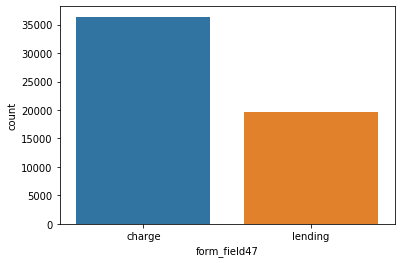

In [10]:
#countplot of form_field47 feature..
sns.countplot(x='form_field47',data=Train)

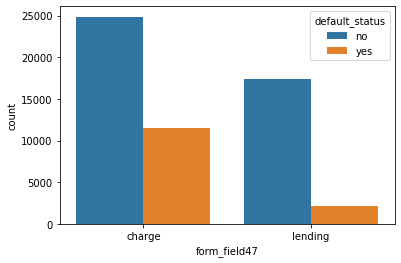

In [11]:
#frequency distribution of form_field47 variable with respect to the target variable 'default_status'
sns.countplot(x='form_field47',hue='default_status',data=Train)

#### DATA PREPROCESSING....

In [12]:
fill_arbitary(Train.drop(["Applicant_ID","default_status"],axis=1))
                        
                       

In [13]:
Train.default_status.replace({"yes":1,"no":0},inplace=True)

In [14]:
te = TargetEncoder()
a = pd.DataFrame(Train.form_field47)
b = pd.DataFrame(Test.form_field47)




X_target_encoded = te.fit(a,Train["default_status"])
Train =X_target_encoded.transform(Train)
Test = X_target_encoded.transform(Test)




Extract training data, test data and target

In [15]:
train = Train.drop(["Applicant_ID","default_status"],1)
target = Train["default_status"]

test = Test.drop(["Applicant_ID"],1)



In [16]:
skf = StratifiedKFold(n_splits = 10,shuffle=True,random_state=199)

#### BUILDING MODELS...

### MODEL 1: LIGHTGBM(1)

In [17]:

lgb_model = lgbm.LGBMClassifier(random_state=34, n_estimators=5000,colsample_bytree=0.9,min_child_samples=10,
    subsample=0.7,subsample_freq=2,num_leaves=120,reg_lambda=2,reg_alpha=5 ,metric='auc', learning_rate=0.008,
    max_depth=5)
LGB1__train, LGB1_test, LGB1_name =lgb_predict(lgb_model,train, target, test,'lightgbm(1)')


========================Fold1==========================
Training until validation scores don't improve for 200 rounds
[250]	valid_0's auc: 0.82723
[500]	valid_0's auc: 0.830998
[750]	valid_0's auc: 0.833157
[1000]	valid_0's auc: 0.834379
[1250]	valid_0's auc: 0.834906
[1500]	valid_0's auc: 0.835241
[1750]	valid_0's auc: 0.835256
Early stopping, best iteration is:
[1599]	valid_0's auc: 0.835322

Validation scores 0.8353217054484172

Training scores 0.8734712895727837
========================Fold2==========================
Training until validation scores don't improve for 200 rounds
[250]	valid_0's auc: 0.828902
[500]	valid_0's auc: 0.833391
[750]	valid_0's auc: 0.835315
[1000]	valid_0's auc: 0.836351
[1250]	valid_0's auc: 0.836793
[1500]	valid_0's auc: 0.836931
Early stopping, best iteration is:
[1503]	valid_0's auc: 0.836946

Validation scores 0.836946415109179

Training scores 0.8717164205500751
========================Fold3==========================
Training until validation scores 

### MODEL 2: CATBOOST(1)

In [20]:
catboost =  CatBoostClassifier(random_seed=34,use_best_model=True,
                          n_estimators=5000,silent=True,eval_metric='AUC')


cat1_train, cat1_test, cat1_name = cat_predict(catboost,train, target, test,  'catboost(1)')


========================Fold1==========================
Learning rate set to 0.041434
0:	test: 0.7957900	best: 0.7957900 (0)	total: 588ms	remaining: 48m 58s
250:	test: 0.8347772	best: 0.8347772 (250)	total: 19.6s	remaining: 6m 10s
500:	test: 0.8358065	best: 0.8358472 (498)	total: 35.8s	remaining: 5m 21s
750:	test: 0.8352850	best: 0.8359142 (602)	total: 51.9s	remaining: 4m 53s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8359141553
bestIteration = 602

Shrink model to first 603 iterations.

Testing scores 0.8359141553087905

Training scores 0.8763953900831206
========================Fold2==========================
Learning rate set to 0.041434
0:	test: 0.7994374	best: 0.7994374 (0)	total: 142ms	remaining: 11m 47s
250:	test: 0.8365111	best: 0.8365257 (245)	total: 18.6s	remaining: 5m 52s
500:	test: 0.8377243	best: 0.8377917 (392)	total: 35.1s	remaining: 5m 14s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8377917126
bestIteration = 392

Shrin

### MODEL 3: CATBOOST(2)

In [21]:
catboost2 =  CatBoostClassifier(random_seed=34,bootstrap_type='Bayesian',max_depth=6,learning_rate=0.007,
                          iterations=8000,silent=True,eval_metric='AUC')


cat2_train, cat2_test, cat2_name = cat_predict(catboost2,train, target, test,  'catboost(2)')


========================Fold1==========================
0:	test: 0.7935997	best: 0.7935997 (0)	total: 257ms	remaining: 34m 14s
250:	test: 0.8272039	best: 0.8272039 (250)	total: 22.3s	remaining: 11m 28s
500:	test: 0.8303926	best: 0.8303926 (500)	total: 39.4s	remaining: 9m 50s
750:	test: 0.8318572	best: 0.8318660 (748)	total: 56.1s	remaining: 9m 1s
1000:	test: 0.8329971	best: 0.8329971 (1000)	total: 1m 13s	remaining: 8m 31s
1250:	test: 0.8337541	best: 0.8337541 (1250)	total: 1m 30s	remaining: 8m 6s
1500:	test: 0.8343948	best: 0.8344043 (1499)	total: 1m 47s	remaining: 7m 43s
1750:	test: 0.8347812	best: 0.8347839 (1748)	total: 2m 3s	remaining: 7m 22s
2000:	test: 0.8351992	best: 0.8351994 (1999)	total: 2m 17s	remaining: 6m 52s
2250:	test: 0.8354635	best: 0.8354649 (2247)	total: 2m 31s	remaining: 6m 26s
2500:	test: 0.8356544	best: 0.8356625 (2497)	total: 2m 45s	remaining: 6m 3s
2750:	test: 0.8357736	best: 0.8357736 (2750)	total: 2m 59s	remaining: 5m 41s
3000:	test: 0.8358717	best: 0.8358779 

1250:	test: 0.8448992	best: 0.8448992 (1250)	total: 1m 12s	remaining: 6m 32s
1500:	test: 0.8456053	best: 0.8456124 (1498)	total: 1m 26s	remaining: 6m 15s
1750:	test: 0.8459984	best: 0.8460198 (1741)	total: 1m 40s	remaining: 5m 58s
2000:	test: 0.8463268	best: 0.8463375 (1991)	total: 1m 54s	remaining: 5m 43s
2250:	test: 0.8466954	best: 0.8467033 (2248)	total: 2m 7s	remaining: 5m 26s
2500:	test: 0.8469639	best: 0.8469724 (2491)	total: 2m 21s	remaining: 5m 11s
2750:	test: 0.8471631	best: 0.8471751 (2743)	total: 2m 35s	remaining: 4m 56s
3000:	test: 0.8472765	best: 0.8473044 (2987)	total: 2m 49s	remaining: 4m 42s
3250:	test: 0.8474268	best: 0.8474320 (3249)	total: 3m 3s	remaining: 4m 27s
3500:	test: 0.8475876	best: 0.8476242 (3463)	total: 3m 17s	remaining: 4m 13s
3750:	test: 0.8476557	best: 0.8476573 (3748)	total: 3m 31s	remaining: 3m 59s
4000:	test: 0.8477914	best: 0.8478116 (3981)	total: 3m 45s	remaining: 3m 45s
4250:	test: 0.8478154	best: 0.8478833 (4154)	total: 3m 58s	remaining: 3m 30s
S

4000:	test: 0.8448827	best: 0.8449165 (3938)	total: 3m 42s	remaining: 3m 42s
4250:	test: 0.8448484	best: 0.8449179 (4099)	total: 3m 56s	remaining: 3m 28s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8449178529
bestIteration = 4099

Shrink model to first 4100 iterations.

Testing scores 0.8449178529365524

Training scores 0.8738885961450419
Average Testing ROC score for 10 folds split: 0.8416457232003705
Average Training ROC score for 10 folds split: 0.8751757480026956
standard Deviation for 10 folds split: 0.004604869898856821


### MODEL 4 : LIGHTGBM(2)

In [23]:

lgb_model2 = lgbm.LGBMClassifier(random_state=34, n_estimators=5000,colsample_bytree=0.9,min_child_samples=10,
    subsample=0.5,subsample_freq=2,num_leaves=120,reg_lambda=2,reg_alpha=5 ,metric='auc', learning_rate=0.008,
    max_depth=5)
LGBM2_train, LGBM2_test, LGBM2_name= lgb_predict(lgb_model2,train, target, test,  'lightgbm(2)')


========================Fold1==========================
Training until validation scores don't improve for 200 rounds
[250]	valid_0's auc: 0.827581
[500]	valid_0's auc: 0.83103
[750]	valid_0's auc: 0.833122
[1000]	valid_0's auc: 0.834475
[1250]	valid_0's auc: 0.835164
[1500]	valid_0's auc: 0.835381
Early stopping, best iteration is:
[1444]	valid_0's auc: 0.835439

Validation scores 0.8354386431501155

Training scores 0.8697380048857971
========================Fold2==========================
Training until validation scores don't improve for 200 rounds
[250]	valid_0's auc: 0.829749
[500]	valid_0's auc: 0.833681
[750]	valid_0's auc: 0.835792
[1000]	valid_0's auc: 0.837001
[1250]	valid_0's auc: 0.83729
[1500]	valid_0's auc: 0.837399
Early stopping, best iteration is:
[1304]	valid_0's auc: 0.837473

Validation scores 0.8374731521902794

Training scores 0.8667644901241149
========================Fold3==========================
Training until validation scores don't improve for 200 rounds
[2

### MODEL 5: RANDOM FORESTS(1)

In [24]:
rf1_model = RandomForestClassifier(n_jobs=-1,criterion='entropy',min_samples_split=10,n_estimators=400,random_state=99)
rf1_train, rf1_test, rf1_name = model_predict(rf1_model,train, target, test, 'RandomForest(1)')


========================Fold1==========================

Validation scores 0.8308597904883426

Training scores 0.9994967550293589
========================Fold2==========================

Validation scores 0.8326266191257993

Training scores 0.9995233237309932
========================Fold3==========================

Validation scores 0.8340319412400122

Training scores 0.9995151579157964
========================Fold4==========================

Validation scores 0.8437676085670837

Training scores 0.9994997065160038
========================Fold5==========================

Validation scores 0.8345896374914001

Training scores 0.9995359130508766
========================Fold6==========================

Validation scores 0.8431613759167675

Training scores 0.9995114825299543
========================Fold7==========================

Validation scores 0.8312485691668207

Training scores 0.9994986668630205
========================Fold8==========================

Validation scores 0.8312311578233

### MODEL 6: RANDOM FORESTS(2)

In [25]:
rf_model2 = RandomForestClassifier(max_depth=10,min_samples_split=10,min_samples_leaf=15,n_estimators=400,n_jobs=-1,random_state=34)
rf2_train, rf2_test, rf2_name= model_predict( rf_model2,train, target, test, 'RandomForest(2)')


========================Fold1==========================

Validation scores 0.8287061015781587

Training scores 0.879419820916435
========================Fold2==========================

Validation scores 0.8308459925294401

Training scores 0.8793232573843832
========================Fold3==========================

Validation scores 0.8320115751077233

Training scores 0.8788761619725123
========================Fold4==========================

Validation scores 0.8400288791279827

Training scores 0.8782773667461575
========================Fold5==========================

Validation scores 0.8311167774729002

Training scores 0.8787436516108675
========================Fold6==========================

Validation scores 0.8402940207032941

Training scores 0.8783288277074531
========================Fold7==========================

Validation scores 0.8238815021886574

Training scores 0.8788595410802063
========================Fold8==========================

Validation scores 0.82685246351547

### MODEL 7: XGBOOST(1)

In [26]:
from xgboost import XGBClassifier
Xgboost = XGBClassifier(learning_rate=0.01,subsample=0.7,colsample_bytree=0.9,reg_alpha=10,
               n_jobs=-1,n_estimators=5000,max_depth= 5,random_state=34)

xgb_train, xgb_test, xgb_name= xgb_predict(Xgboost,train, target, test,'xgboost')


========================Fold1==========================
[0]	validation_0-auc:0.78424
Will train until validation_0-auc hasn't improved in 200 rounds.
[250]	validation_0-auc:0.82764
[500]	validation_0-auc:0.83101
[750]	validation_0-auc:0.83296
[1000]	validation_0-auc:0.83402
[1250]	validation_0-auc:0.83466
[1500]	validation_0-auc:0.83475
[1750]	validation_0-auc:0.83473
Stopping. Best iteration:
[1689]	validation_0-auc:0.83483


Testing scores 0.8348318779073809

Training scores 0.8765534143597913
========================Fold2==========================
[0]	validation_0-auc:0.78883
Will train until validation_0-auc hasn't improved in 200 rounds.
[250]	validation_0-auc:0.82926
[500]	validation_0-auc:0.83372
[750]	validation_0-auc:0.83592
[1000]	validation_0-auc:0.83677
[1250]	validation_0-auc:0.83720
[1500]	validation_0-auc:0.83733
[1750]	validation_0-auc:0.83736
Stopping. Best iteration:
[1589]	validation_0-auc:0.83748


Testing scores 0.8374760842565462

Training scores 0.874550582141731

### MODEL 8: GRADIENT BOOSTING MACHINES..

In [27]:
gbm_model = GradientBoostingClassifier(max_depth=4,min_samples_leaf=10,n_estimators=200,learning_rate=0.1,min_samples_split=10,random_state=10)
gbm_train, gbm_test, gbm_name= model_predict(gbm_model,train, target, test, 'Gbm')


========================Fold1==========================

Validation scores 0.8330371084031468

Training scores 0.8707550341782366
========================Fold2==========================

Validation scores 0.8353472316723869

Training scores 0.8712694390253557
========================Fold3==========================

Validation scores 0.8405669132879346

Training scores 0.8695435069184125
========================Fold4==========================

Validation scores 0.8462846149826173

Training scores 0.8696511409202062
========================Fold5==========================

Validation scores 0.8387300600090479

Training scores 0.8703997754494486
========================Fold6==========================

Validation scores 0.8454707923850714

Training scores 0.8704792295815413
========================Fold7==========================

Validation scores 0.8329771190811774

Training scores 0.8706396925886813
========================Fold8==========================

Validation scores 0.8313357120791

### STACKING

- Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or regressor.. Here the base level models are trained  on the training set via cross validation, and the meta model(LinearRegression) is then trained on the predictions of the base level models as features in order to fine tune our predictions....

In [51]:

Train_stack3 = pd.DataFrame(xgb_train)
Train_stack3 = pd.concat([Train_stack3,pd.DataFrame(rf1_train),pd.DataFrame(rf2_train),
                        pd.DataFrame(LGB1__train),pd.DataFrame(LGBM2_train),pd.DataFrame(cat1_train),pd.DataFrame(cat2_train),
                         pd.DataFrame(gbm_train)],1)
Test_stack3 = pd.DataFrame(xgb_test)
Test_stack3 = pd.concat([Test_stack3,pd.DataFrame(rf1_test),pd.DataFrame(rf2_test),
                        pd.DataFrame(LGB1_test),pd.DataFrame(LGBM2_test),pd.DataFrame(cat1_test),pd.DataFrame(cat2_test),
                        pd.DataFrame(gbm_test)],1)
Test_stack3.columns=[xgb_name,rf1_name,rf2_name,LGB1_name,LGBM2_name,cat1_name,cat2_name,gbm_name]
Train_stack3.columns=[xgb_name,rf1_name,rf2_name,LGB1_name,LGBM2_name,cat1_name,cat2_name,gbm_name]
Test_stack3 = Test_stack3/10 #average predictions for 1o folds on the Test set..
Test_stack3.head()

,xgboost,RandomForest(1),RandomForest(2),lightgbm(1),lightgbm(2),catboost(1),catboost(2),Gbm
0,0.300142,0.350402,0.359993,0.299951,0.297754,0.316275,0.310177,0.353062
1,0.337876,0.376003,0.381340,0.368442,0.362913,0.368979,0.364976,0.338744
2,0.404822,0.392471,0.374665,0.403675,0.402645,0.392726,0.381531,0.414784
3,0.765664,0.679308,0.639713,0.749910,0.755325,0.738753,0.740660,0.738248
4,0.121092,0.214100,0.217011,0.120897,0.132331,0.176077,0.188173,0.190475


In [52]:
meta_estimator = LinearRegression()
Stack(meta_estimator,Train_stack3,Test_stack3,target,'omni_stack.csv')

In [54]:
#CORRELATION BETWEEN PREDICTIONS..
Train_stack3.corr()

,xgboost,RandomForest(1),RandomForest(2),lightgbm(1),lightgbm(2),catboost(1),catboost(2),Gbm
xgboost,1.000000,0.968880,0.962674,0.997712,0.997265,0.987618,0.992022,0.986512
RandomForest(1),0.968880,1.000000,0.984621,0.970204,0.970905,0.965940,0.971328,0.961307
RandomForest(2),0.962674,0.984621,1.000000,0.965007,0.966236,0.961341,0.967778,0.958240
lightgbm(1),0.997712,0.970204,0.965007,1.000000,0.997941,0.988750,0.993036,0.987702
lightgbm(2),0.997265,0.970905,0.966236,0.997941,1.000000,0.988544,0.993151,0.986610
catboost(1),0.987618,0.965940,0.961341,0.988750,0.988544,1.000000,0.994138,0.983241
catboost(2),0.992022,0.971328,0.967778,0.993036,0.993151,0.994138,1.000000,0.986557
Gbm,0.986512,0.961307,0.958240,0.987702,0.986610,0.983241,0.986557,1.000000


#### **Best Model Stack LB** :0.845389667355..


**FURTHER IMPROVEMENTS**
*   I used have used One Hot Encoding instead as it does better than target encoding as target encoding tends to introduce noise into the encoding of the categorical variables(noise which were originally from the target variable itself) and as such can cause data leakages leading to overfitting and poor predictive performance...
*   Feature engineering
*   Outlier handling
*   Train the different models on different random_seeds so as not to overfit a paticular seed
*   Removing the different features that were detrimental to the individual model's performance.








